# <u>**Coding Challenge 2023 / 2024: Concrete Rules**</u>
#### Group (6) Members: Aakash Dharmaraj, Ry Nduma, Felix Watson, Mervyn Ochoa-Dugoy
# **Overview**

**Preprocessing:**

A class called **PreProcessing** was implemented, which includes functions such as <i>FillNaN</i> and <i>Transform</i>. For <i>FillNaN</i>, the classification method **KNNInputer** from the sklearn.impute module was used to replace all missing (NaN) values for each variable by selecting the best appropriate number according to the nearest neighbours of the given data point. The effect on the data was visualised through distribution plots and scatter graphs, observing trends. These observations were then used to apply appropriate <u>transformations</u> (e.g. Logarithmic) such that each variable displayed the best possible linear relationship with the the output variable, <u>compressive strength</u>. 

To ensure the best linear relationship, a <u>skewness score</u> was implemented to check how well distributed the variable data was, more information about which can be found here: https://pyshark.com/skewness-in-python/. This is useful as normality plays a crucial role in the performance of regression models later on.

**Regression Model**

Prior to performing the regression models, the data was split into training and test sets using the <i>train_test_split</i> function from the sklearn.model.selection module. Using a class called **RegressionModel**, cross validation scores were compared using heatmaps to find suitable parameters, or <u>hyperparameters</u>, for each regression method. These optimised parameters were visualised in plots and error analysis and thus can be used to find a rational regression method, as well as other practical considerations. By using this regression method, the <u>coefficients</u> for each input variable can be obtained for the interactive graph.

**Interactive Graph**

Using the coefficients obtained by the chosen regression method, and using the transformations applied during pre-processing, an interactive graph was plotted, which describes the relationships each <u>input variable</u> has with the <u>compressive strength</u> of concrete. Using sliders, the effect of the mixture on the final compressive strength can be visualised.

(*Note*: specific comments are included in cells and markdowns for clarity)

In [1]:
# Run this cell so the rest of the code can work!
import warnings
warnings.filterwarnings('ignore') # ignores any warnings that appear from libraries, e.g. seaborn.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from matplotlib.widgets import Button, Slider

# ** Constructing the Preprocessing Class**

In [2]:
filename = 'Concrete_Data_Yeh_final.csv'
# Input variables: cement, slag, flyash, water, superplasticizer, coarseaggregate, fineaggregate, age
# Output variable: csMPa

class PreProcessing:
    '''Aim of Class: To successfully modify the file given, with the most appropriate preprocessing methods. 
    This includes either replacing or removing the NaN values, and applying relevant transformations to the data.'''
    def __init__(self, file):
        # Initialises the class with the file name.
        self.data = pd.read_csv(file)

    def checkNaN (self):
        # To check the number of NaN values from each variable.
        return self.data.isnull().sum()

    def FillNaN(self, method='knn') -> pd.DataFrame:
        # Fills each variables missing values with specified method.
        if method == 'mean':
            # Replaces all column NaN values with their respective mean (considered, but not used).
            for variable in self.data.columns[:-1]:
                self.data[variable].fillna(self.data[variable].mean(), inplace = True)

        elif method == 'median':
            # Replaces all column NaN values with their respective median (considered, but not used).
            for variable in self.data.columns[:-1]:
                self.data[variable].fillna(self.data[variable].median(), inplace = True)

        elif method == 'knn':
            # Replaces all column NaN values with values predicted by KNN imputer classification method (Considered and used).
            data = self.data.values

            # Split into input and output elements and print total missing prior to KNN. 
            ix = [i for i in range(data.shape[1]) if i != 8]
            X, y = data[:, ix], data[:, 8]
            print('Total Data Values Missing: %d' % sum(np.isnan(X).flatten()))

            # Initiates KNNImputer to replace NaN values with predicted values and checking total missing after to see if it was successful.
            imputer = KNNImputer()
            imputer.fit(X)
            Xtrans = imputer.transform(X)
            print('Total Data Values Missing after imputing KNN: %d' % sum(np.isnan(Xtrans).flatten()))

            # Replaces the original data with the imputed data.
            df= pd.DataFrame(Xtrans)
            df.insert(len(df.columns), 'csMPa', y)
            df.columns = self.data.columns
            self.data = df

        else:
            # Raises an error if the method is not recognised.
            raise ValueError("Invalid imputation method.")

        return self.data

    def RemoveNaN (self) -> pd.DataFrame:
        # Removes any row that contains any NaN values from the original dataset (considered, but not used).
        return self.data.dropna(inplace = True)

    def Transform (self) -> pd.DataFrame:
        # Applies relevant transformations to the data for specified columns for optimisation in regression, inheriting FillNaN method.
        trandata = self.FillNaN('knn')                       #       
        trandata['cement'] = trandata['cement'].apply(lambda x: np.sqrt(x))
        trandata['slag'] = trandata['slag'].apply(lambda x:np.log(x+1))
        trandata['superplasticizer'] = trandata['superplasticizer'].apply(lambda x: np.sqrt(x**(4/3)))
        trandata['age'] = trandata['age'].apply(lambda x: np.exp(1-(28/x)))
        return trandata

### Count the number of NaN values in each variable

In [3]:
# Check for existing NaN values in the dataset.
checkNaNs = PreProcessing(filename).checkNaN()
checkNaNs

cement               0
slag                 6
flyash               1
water                8
superplasticizer    14
coarseaggregate      7
fineaggregate        3
age                  5
csMPa                0
dtype: int64

### Processed Database

In [4]:
'''For reference, preprocessed: CD = Concrete Data and TCD = Transformed Concrete Data'''
CD = PreProcessing(filename).FillNaN('knn') # Fills all NaN values with KNN imputer.
CD.describe()   # General statistics of the data for each variable in the original database.

Total Data Values Missing: 44
Total Data Values Missing after imputing KNN: 0


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.00000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.847903,54.19866,181.570369,6.215068,972.784699,773.580252,45.428155,35.817961
std,104.506364,86.220315,64.00873,21.271200,5.964942,77.717326,80.159764,62.371898,16.705742
min,102.000000,0.000000,0.00000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.00000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.00000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.30000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.10000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


### Transformed Database

In [5]:
TCD = PreProcessing(filename).Transform()   # Applies transformations to the data.
TCD.describe() # General statistics of the data for each variable in the transformed .

Total Data Values Missing: 44
Total Data Values Missing after imputing KNN: 0


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.00000,1030.000000,1030.000000,1030.000000,1030.000000,1.030000e+03,1030.000000
mean,16.479268,2.553403,54.19866,181.570369,2.841366,972.784699,773.580252,9.836483e-01,35.817961
std,3.100148,2.411536,64.00873,21.271200,2.413052,77.717326,80.159764,7.401023e-01,16.705742
min,10.099505,0.000000,0.00000,121.800000,0.000000,801.000000,594.000000,1.879529e-12,2.330000
25%,13.869912,0.000000,0.00000,164.900000,0.000000,932.000000,730.950000,4.978707e-02,23.710000
50%,16.519685,3.135494,0.00000,185.000000,3.447096,968.000000,779.500000,1.000000e+00,34.445000
75%,18.708287,4.969466,118.30000,192.000000,4.703272,1029.400000,824.000000,1.648721e+00,46.135000
max,23.237900,5.887215,200.10000,247.000000,10.121322,1145.000000,992.600000,2.517554e+00,82.600000


### Correlation Matrix

Typically a correlation matrix is used to display the strength and direction of the linear relationship between each variable. Looking at the "csMPa" or <i>compressive strength</i> row, it is observed that the variables with the greatest correlations with strength are <u>cement</u>, <u>superplasticizer</u> and <u>age</u>, all having positive correlations also. Conversely, <u>water</u> has the most negative correlation with strength.

In [6]:
CD.corr().style.background_gradient(cmap='coolwarm')

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
cement,1.000000,-0.275391,-0.397501,-0.080717,0.090216,-0.108566,-0.222729,0.079688,0.497832
slag,-0.275391,1.000000,-0.323409,0.109913,0.041009,-0.287225,-0.281997,-0.046032,0.133628
flyash,-0.397501,-0.323409,1.000000,-0.258555,0.381479,-0.008929,0.079306,-0.153183,-0.105841
water,-0.080717,0.109913,-0.258555,1.000000,-0.656387,-0.181684,-0.450139,0.274422,-0.291351
superplasticizer,0.090216,0.041009,0.381479,-0.656387,1.000000,-0.263948,0.222991,-0.192707,0.365045
coarseaggregate,-0.108566,-0.287225,-0.008929,-0.181684,-0.263948,1.000000,-0.178383,0.000862,-0.165439
fineaggregate,-0.222729,-0.281997,0.079306,-0.450139,0.222991,-0.178383,1.000000,-0.151734,-0.167119
age,0.079688,-0.046032,-0.153183,0.274422,-0.192707,0.000862,-0.151734,1.000000,0.329289
csMPa,0.497832,0.133628,-0.105841,-0.291351,0.365045,-0.165439,-0.167119,0.329289,1.000000


### Scaling the Data
Here variables were scaled, ensuring suitability for later regression techniques. Distribution and scatter plots were also generated for each scaled variable.

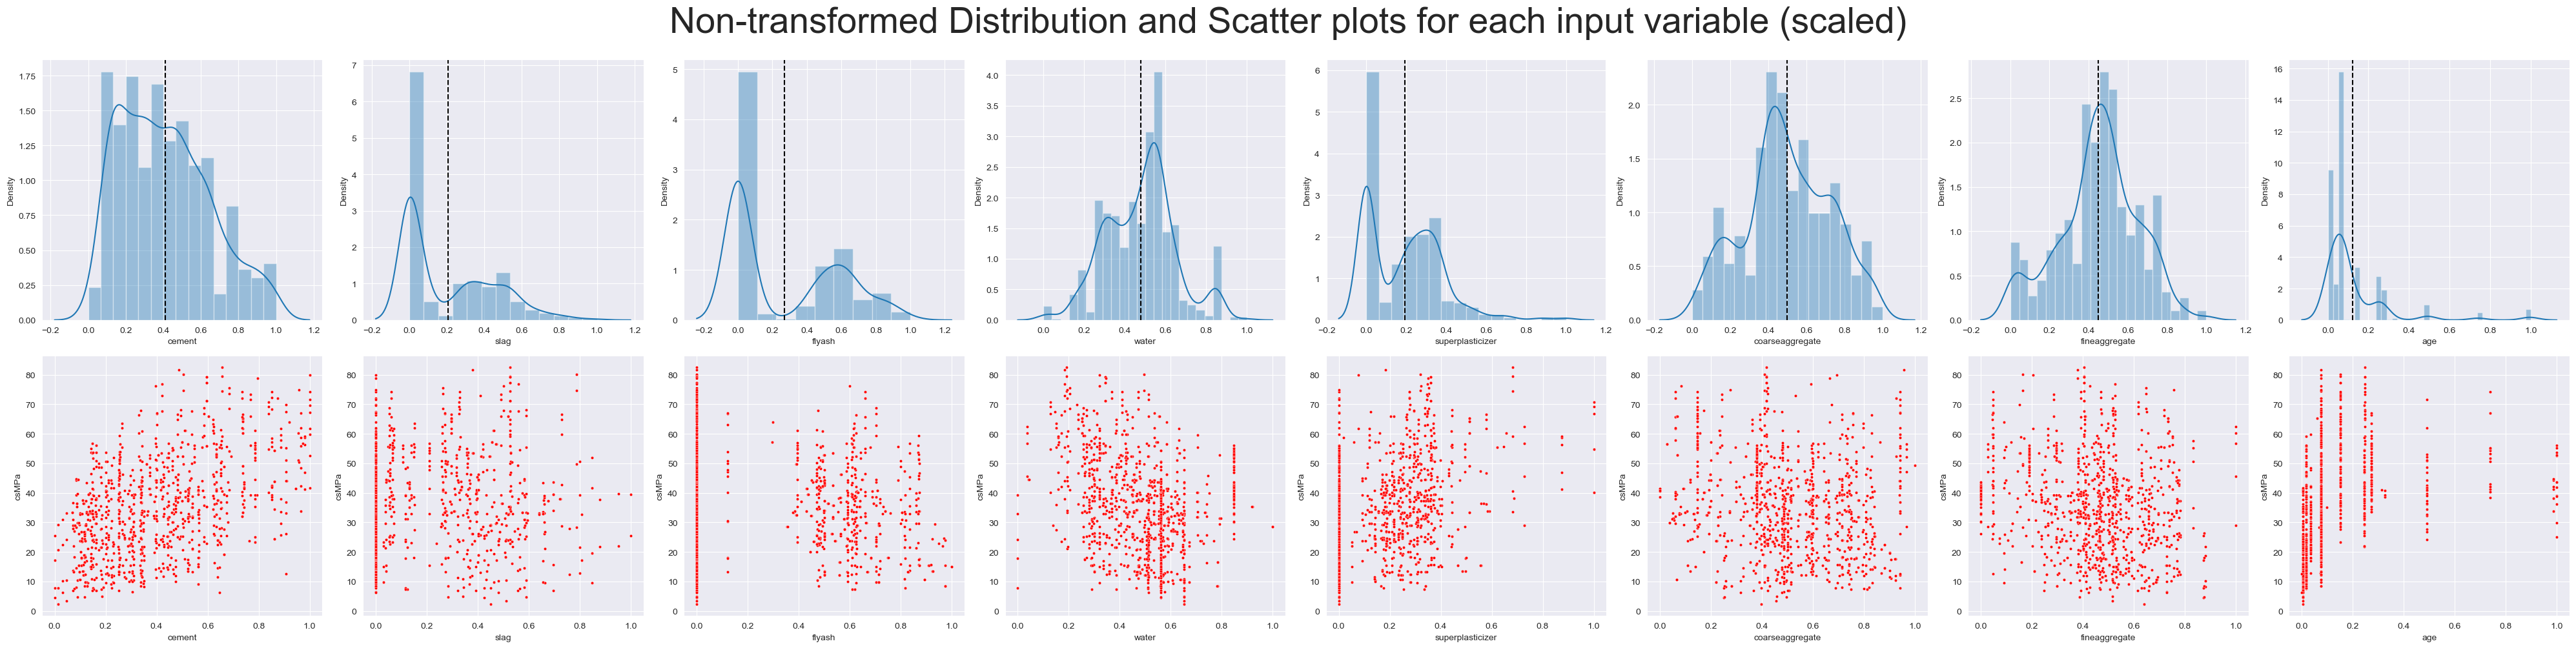

Non-transformed skewness data
            Variable  Skewness
0            cement  0.508739
1              slag  0.800379
2            flyash  0.536419
3             water  0.077448
4  superplasticizer  0.898003
5   coarseaggregate -0.036001
6     fineaggregate -0.253097
7               age  3.273802


In [7]:
# Scales all input variables using MinMaxScaler from sklearn.preprocessing (applied to both CD and TCD).
scaler = MinMaxScaler()
CD.iloc[:,:-1] = scaler.fit_transform(CD.iloc[:,:-1])

# Plotting distribution and scatter plots for the non-transformed data to observe initial trends and skewness.
fig, axs = plt.subplots(2, 8, figsize=(40, 10))
fig.suptitle('Non-transformed Distribution and Scatter plots for each input variable (scaled)', y = 1, fontsize = 40)

df = {'Variable': [], 'Skewness': []}
for i, input in enumerate(CD.columns[:-1]):
    # Adds the name of the variable and its skewness to the df dictionary.
    df['Variable'].append(input)
    df['Skewness'].append(skew(CD[input]))

    # Plots the distribution and scatter plots for each variable.
    sns.distplot(CD[input], ax=axs[0, i])
    axs[0,i].axvline(CD[input].mean(),linestyle="dashed",label="mean", color='black')
    sns.scatterplot(x=CD[input], y=CD['csMPa'], ax=axs[1, i], color = 'red', s = 10)

plt.tight_layout()
plt.show()

# Prints the skewness of each variable of CD in a dataframe.
print('\033[1m' + 'Non-transformed skewness data\n' + '\033[0m', pd.DataFrame(df))  

### Interpreting the pre-processed data
Looking at all the evidence (correlation matrix, distribution plots, scatter graphs, skewness results and the scaled DataFrame), it was decided best to proceed with the following variables (brief reasons are included):
- **Cement**: <u>Square Root</u> transformation - the distribution plot became slightly more gaussian; skewness due to high density of low values was reduced.
- **Slag**: <u>Logarithmic</u> transformation - emphasises the frequency of non zero values; the distribution became more normalised.
- **Flyash**: <u>REMOVED</u> - caused multicolinearity with other input variables and had the lowest gradient relationship with compressive strength. The presence of a lot of noise in the scatter plot also supports this conclusion.
- **Water**: <u>No</u> transformation - The skewness result was close to zero, signifying near-perfect normality of data.
- **Superplasticizer**: <u>Square Root</u> transformation - a strong positive trend occurred at low superplasticizer values; became less clear if continued at higher values.
- **Coarse aggregate**: <u>No</u> transformation - no defined trend was seen, there was a wide spread of data points.
- **Fine aggregate**: <u>No</u> transformation - slight negative correlation with compressive strength, displayed initial linearity regardless.
- **Age**: <u>Logarithmic</u> transformation - a curved increase in strength with a slight plateau observed in scatter plot.

**These transformations are seen in the following code below.**

##### Other notable observations:
1. Applying **appropriate transformations** (square root, logarithmic and reciprocal) to columns leads to a more *defined* distibution plot with the data initially held in the database. It is generally observed that **the closer these plots are to the normal gaussian distribution, the closer the data is to the ideal linear relationship** between the input variable and the compressive strength.

2. A few distribution plots, particularly **slag**, **flyash** and **superplasticizer**, have *2* gaussians. This is due to the high amount of null (NaN) values provided from the document. Considering these would skew the regression fit and not represent a reasonable trend with the compressive strength.

3. **Skewness values** were used because, for linear relationships, a **normalised distribution** of data is assumed.

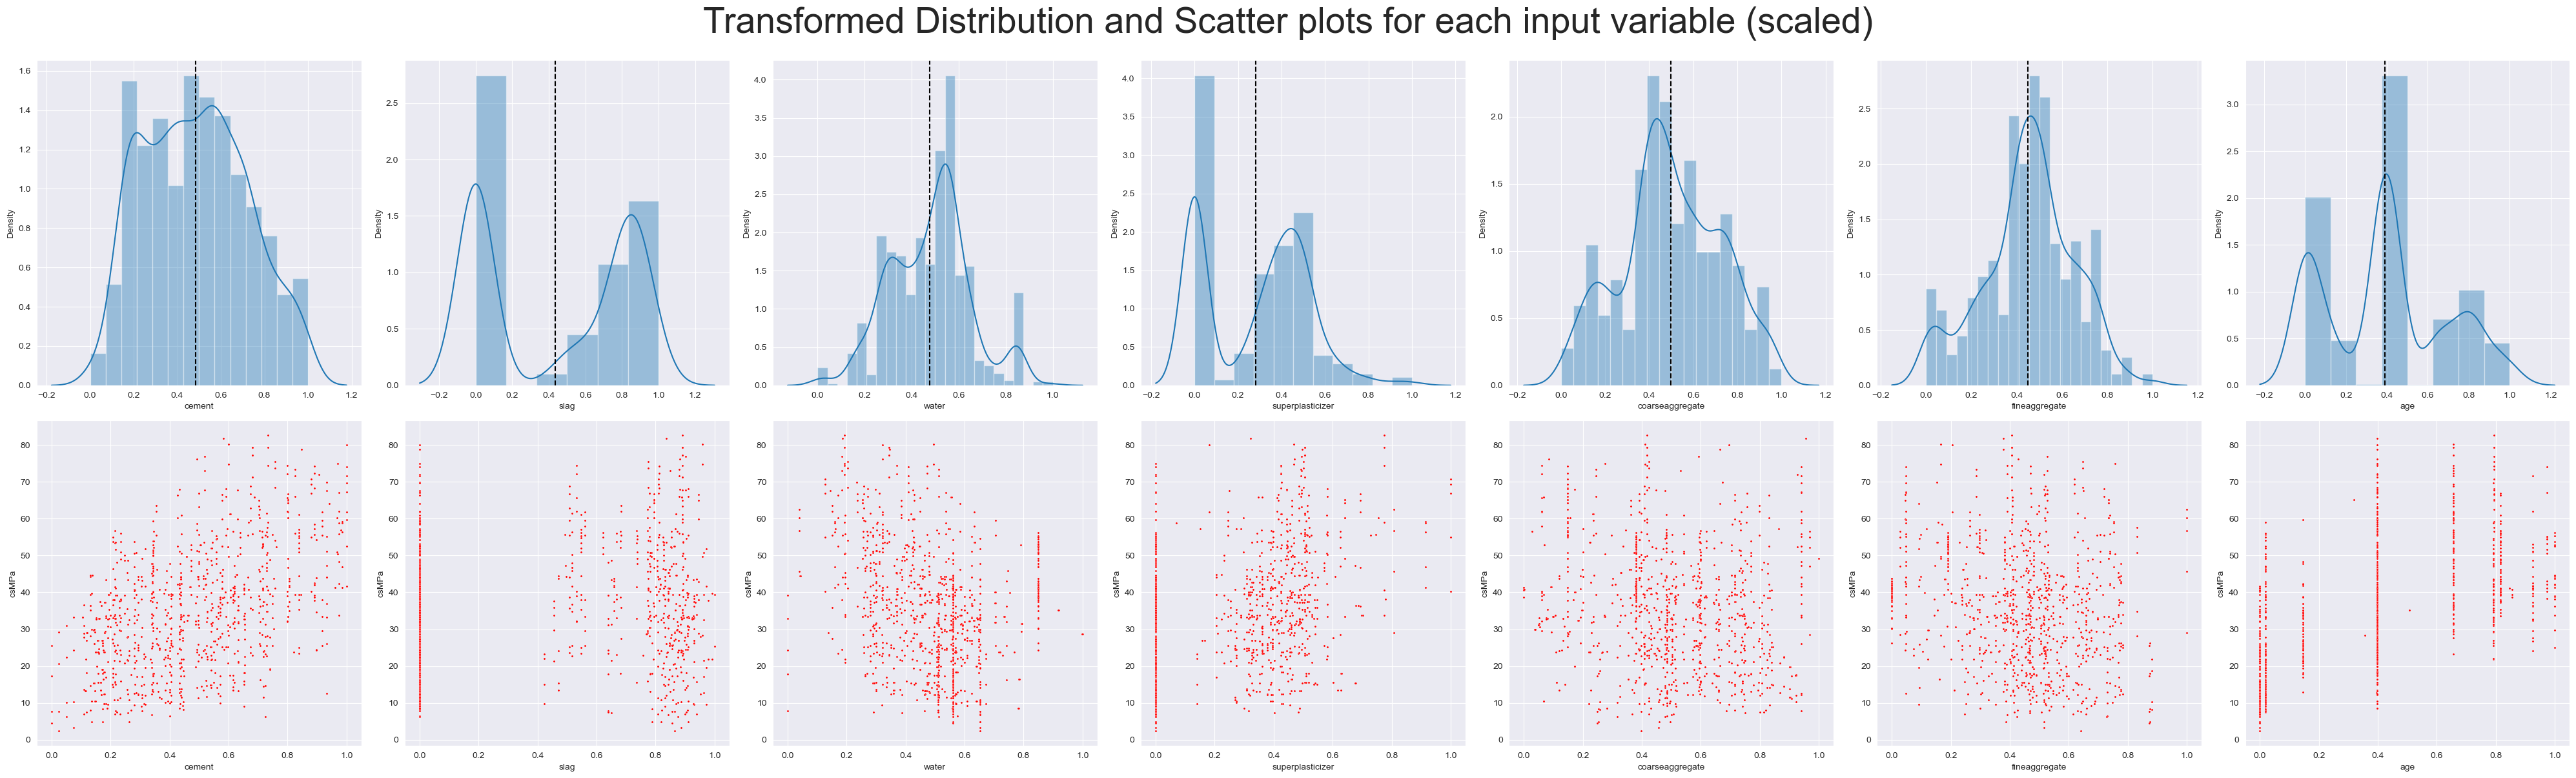

Transformed skewness data
            Variable  Skewness
0            cement  0.189916
1              slag -0.032737
2             water  0.077448
3  superplasticizer  0.117432
4   coarseaggregate -0.036001
5     fineaggregate -0.253097
6               age  0.246819


In [8]:
# Scales all input variables using MinMaxScaler, and removes 'flyash' data from TCD from our observations.
TCD.iloc[:,:-1] = scaler.fit_transform(TCD.iloc[:,:-1])
if 'flyash' in TCD.columns:
    TCD.drop('flyash', axis=1, inplace=True)

# Plotting distribution and scatter plots for the transformed data to observe initial trends and skewness.
fig, axs = plt.subplots(2, (len(TCD.columns)-1), figsize=(40, 12))
fig.suptitle('Transformed Distribution and Scatter plots for each input variable (scaled)', y = 1, fontsize = 40)

df = {'Variable': [], 'Skewness': []}
for i, input in enumerate(TCD.columns[:-1]):
    # Adds the name of the variable and its skewness to the df dictionary.
    df['Variable'].append(input)
    df['Skewness'].append(skew(TCD[input]))

    # Plots the distribution and scatter plots for each variable.
    sns.distplot(TCD[input], ax=axs[0, i])
    axs[0,i].axvline(TCD[input].mean(),linestyle="dashed",label="mean", color='black')
    sns.scatterplot(x=TCD[input], y=TCD['csMPa'], ax=axs[1, i], color = 'red', s = 5)

plt.tight_layout()
plt.show()

# Prints the skewness of each variable of TCD in a dataframe.
print('\033[1m' + 'Transformed skewness data\n' + '\033[0m', pd.DataFrame(df))

# **Regression Model**
##### The following regression models were considered : 
- Linear
- Ridge
- Lasso
- Random Forest 
- Support Vector Regression (SVR).

The training data encompassed **80%** of the database, with the remaining **20%** used for testing. This provided <u>optimal regression</u> and <u>high scores</u> (NB: this did not deduce which regressions were excluded).

### Splitting database

In [9]:
# Splitting the DataFrame into training and testing sets using sklearn's train_test_split function.
X = TCD.iloc[:,:-1].to_numpy() 
y = TCD['csMPa'].to_numpy()

print(f'y:\n{y}\n')
print(f'X:\n{pd.DataFrame(X)}\n') # Checking the data is split correctly (X = 2D array, y = 1D array).

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y:
[79.99 61.89 40.27 ... 23.7  32.77 32.4 ]

X:
             0         1         2         3         4         5         6
0     1.000000  0.000000  0.321086  0.181994  0.694767  0.205720  0.397211
1     1.000000  0.000000  0.321086  0.181994  0.738372  0.205720  0.397211
2     0.619184  0.843580  0.848243  0.000000  0.380814  0.000000  0.973370
3     0.619184  0.843580  0.848243  0.000000  0.380814  0.000000  0.846398
4     0.303922  0.831183  0.560703  0.000000  0.515698  0.580783  0.998935
...        ...       ...       ...       ...       ...       ...       ...
1025  0.496695  0.808901  0.461661  0.424316  0.200872  0.437280  0.397211
1026  0.597518  0.000000  0.592652  0.470744  0.049128  0.550426  0.397211
1027  0.158813  0.839870  0.566294  0.329850  0.265698  0.466633  0.397211
1028  0.191346  0.889189  0.429712  0.497525  0.548256  0.488961  0.397211
1029  0.460703  0.784761  0.629393  0.414726  0.184593  0.420221  0.397211

[1030 rows x 7 columns]


### Checking the general shape of each set

In [10]:
# Checking the shape of both the training and testing sets are reasonable.
print(y_test.shape, y_train.shape, x_test.shape, x_train.shape)

(206,) (824,) (206, 7) (824, 7)


### Regression class

In [11]:
class RegressionModel:
    '''The aim of this class is to successfully fit the regression model to the training data, predict the y values for the 
    testing data, and evaluate the model using the specified metrics and scores. The regressions can be visualised with plots.'''
    def __init__(self, x_train, x_test, y_train, y_test, regression, **kwargs):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.regression = regression(**kwargs)                  # Initiates regression method with any required arguments.
        self.regfit = self.regression.fit(x_train, y_train)     # Fits the regression method to the training data.
        self.y_pred = self.regression.predict(x_test)           # Predicts the y values for the testing data.
    
    def Metric(self, metriclist) -> pd.DataFrame:
        # Performs error analysis on the given regression model using the specified metrics.
        metricdf = {'Metric': [], 'Score': []}
        for metric in metriclist:
            metricdf['Metric'].append(metric.__name__)
            if metric == cross_val_score:
                # Takes the mean of the cross validation scores using the training data.
                metricdf['Score'].append(metric(self.regression, self.x_train, self.y_train, cv=5).mean())
            else:
                # Takes the metric score for the testing data.
                metricdf['Score'].append(metric(self.y_test, self.y_pred))
        return pd.DataFrame(metricdf)
    
    def RegScores(self) -> pd.Series:
        # Compares the regression model scores between the training and testing data.
        difference = np.abs(self.regression.score(self.x_test, self.y_test) - self.regression.score(self.x_train, self.y_train))
        scores = {'Training Score': self.regression.score(self.x_train, self.y_train), 'Testing Score': self.regression.score(self.x_test, self.y_test), 'Difference': difference.round(4)}
        return pd.Series(scores)

    def Plot(self):
        # Visualises the regression model with the given parameters.
        plt.figure(figsize=(6, 4))
        plt.scatter(self.y_test, self.y_pred, color='red', s=5)
        plt.title(f'{self.regression.__class__.__name__} | Score: {self.regression.score(self.x_test, self.y_test)}')
        plt.plot(y_test,y_test, color='black', linestyle = 'dashed')
        plt.xlabel('Actual csMPa')
        plt.ylabel('Predicted csMPa')
        plt.show()
        return
    
    def Coefficients(self)-> np.ndarray:
        # Returns the coefficients for each input variable of the regression model.
        try:
            if self.regression.__class__.__name__ in ['LinearRegression', 'Ridge', 'Lasso', 'SVR']:
                coeffs = self.regression.coef_
            else:
                coeffs = self.regression.feature_importances_
        except AttributeError:
            coeffs = None
        return coeffs

### Finding optimal hyperparameters
NB: Due to their significant runtime, operate RandomForest and SVR heatmaps only if necessary.

In [12]:
'''Performs the root mean squared error for error analysis when operated.'''
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)
alphas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
metriclist = [RMSE, explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, cross_val_score] # List of metrics to be used for error analysis.

##### <u>Linear Regression</u>

In [13]:
model = RegressionModel(x_train, x_test, y_train, y_test, LinearRegression)
cv1_score = model.Metric(metriclist).loc[model.Metric(metriclist)['Metric'] == 'cross_val_score', 'Score'].values[0]
print(f"Cross validation scores for LinearRegression (normalised): {cv1_score}")

Cross validation scores for LinearRegression (normalised): 0.7790014693929928


##### <u>Ridge and Lasso Regression</u>

Text(97.72222222222221, 0.5, 'Alpha')

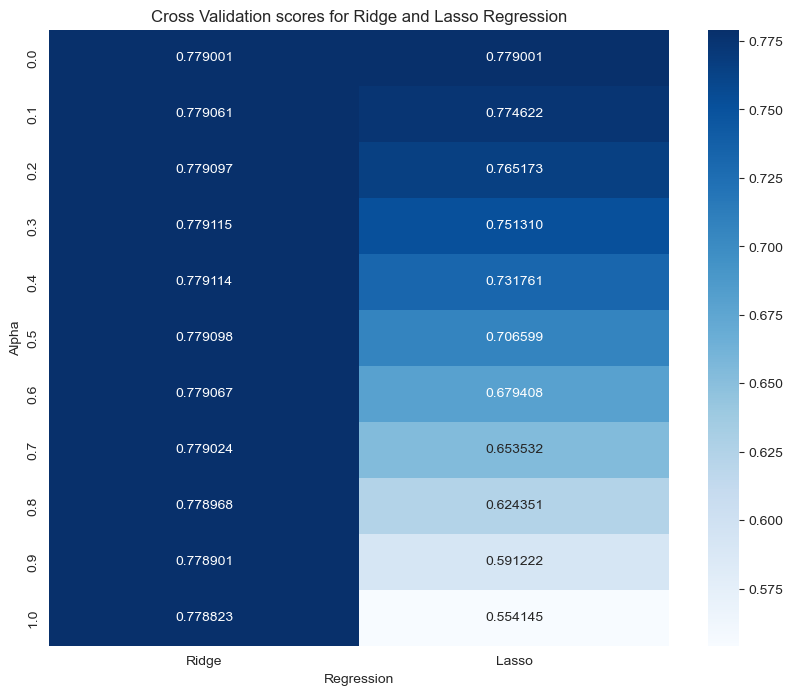

In [14]:
CrossValscores = np.zeros((len(alphas), 2))
for i, regression in enumerate([Ridge, Lasso]):
    for j, alpha in enumerate(alphas):
        if i == 0:
            model = RegressionModel(x_train, x_test, y_train, y_test, regression, alpha = alpha)
        else:
            model = RegressionModel(x_train, x_test, y_train, y_test, regression, alpha = alpha, max_iter = 10000)
        metric_df = model.Metric(metriclist)
        cv_score = metric_df.loc[metric_df['Metric'] == 'cross_val_score', 'Score'].values[0]
        CrossValscores[j][i] = cv_score

# Plotting a heatmap of the cross validation scores for Ridge and Lasso regression.
CrossVal_df = pd.DataFrame(CrossValscores, index=alphas, columns=['Ridge', 'Lasso'])
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(CrossVal_df, annot=True, fmt=".6f", cmap='Blues', ax = ax)
ax.set_title('Cross Validation scores for Ridge and Lasso Regression')
ax.set_xlabel('Regression')
ax.set_ylabel('Alpha')

##### <u>Random Forest Regression</u>

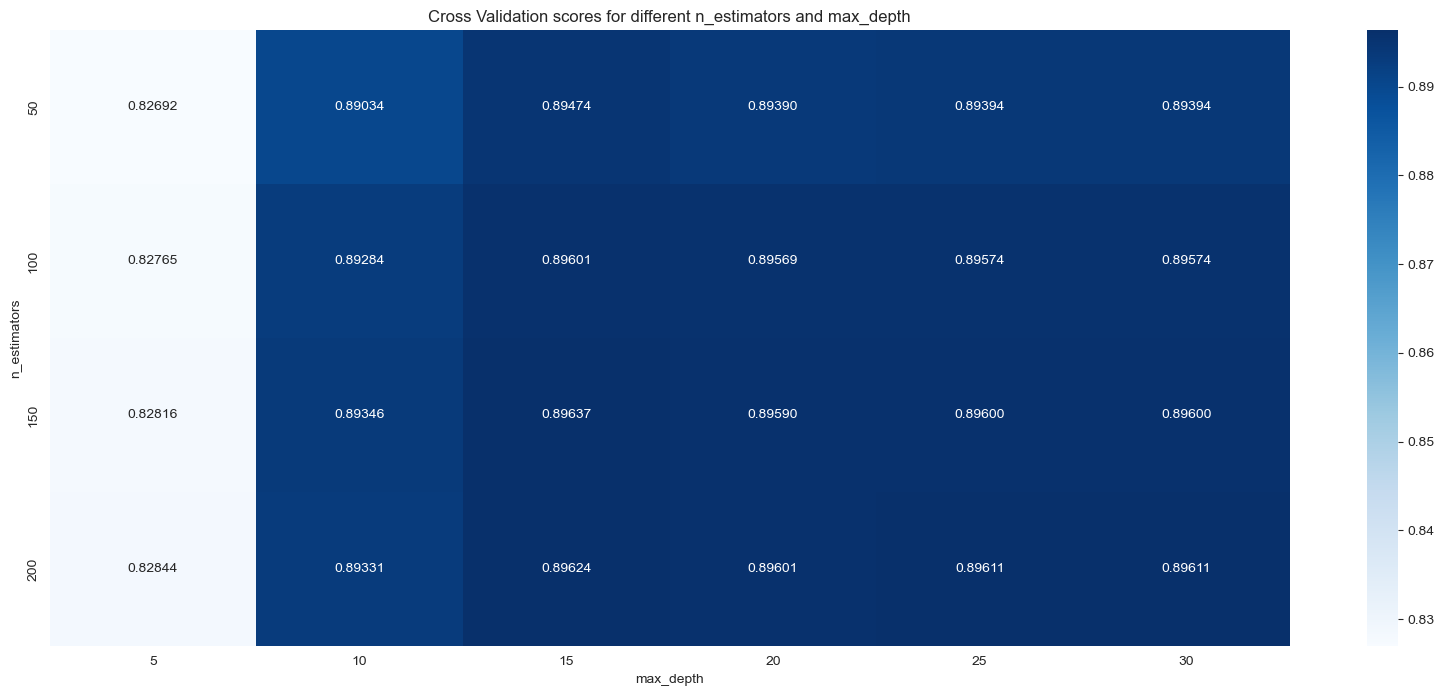

In [15]:
# Performs Random Forest Regressions for all combinations of n_estimators and max_depth, and stores the cross validation scores in a 2D array.
RFscore_values = [[0 for _ in range(6)] for _ in range(4)] 
for i, n_estimators in enumerate([50,100,150,200]):
    for j, max_depth in enumerate([5,10,15,20,25,30]):
        metric_df = RegressionModel(x_train, x_test, y_train, y_test, RandomForestRegressor, n_estimators = n_estimators, max_depth = max_depth, random_state = 42).Metric(metriclist)
        RFscore_values[i][j] = metric_df.loc[metric_df['Metric'] == 'cross_val_score', 'Score'].values[0]

# Plotting a heatmap of the cross validation scores for different n_estimators and max_depth.
RFscore_df = pd.DataFrame(RFscore_values, index=[50,100,150,200], columns=[5,10,15,20,25,30]) #
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(RFscore_df, annot=True, fmt=".5f", cmap='Blues', ax = ax)
ax.set_title('Cross Validation scores for different n_estimators and max_depth')
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
plt.show()

##### <u>Support Vector Regression (SVR)</u>

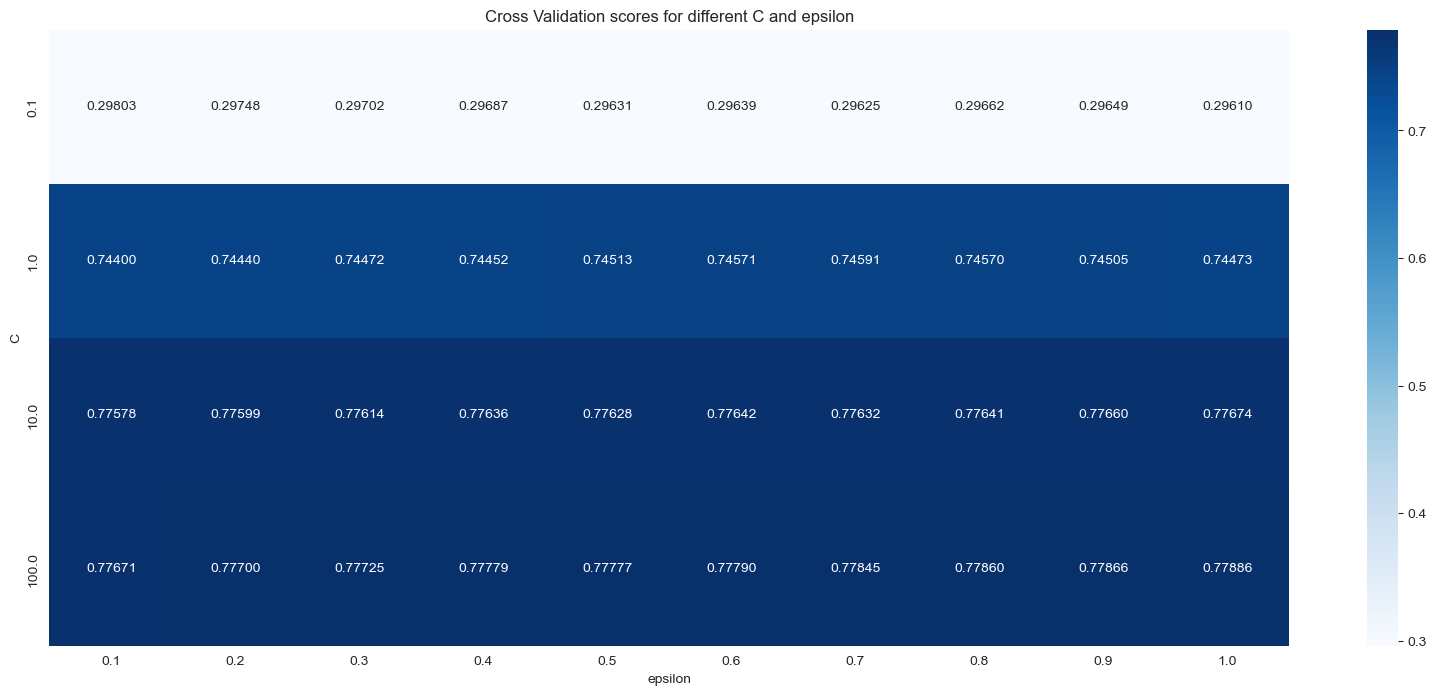

In [16]:
# Performs SVR for all combinations of C and epsilon, and stores the cross validation scores in a 2D array.
SVRscore_values = np.zeros((4,10)) #2D array
for i, c in enumerate([0.1, 1, 10, 100]):
    for j, epsilon in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
        #print(f'n_estimators = {n_estimators}, max_depth = {max_depth}')
        metric_df = RegressionModel(x_train, x_test, y_train, y_test, SVR, kernel = 'linear', C = c, epsilon = epsilon).Metric(metriclist) 
        SVRscore_values[i][j] = metric_df.loc[metric_df['Metric'] == 'cross_val_score', 'Score'].values[0]

# Plotting a heatmap of the cross validation scores for different C and epsilon.
SVRscore_df = pd.DataFrame(SVRscore_values, index=[0.1, 1, 10, 100], columns=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(SVRscore_df, annot=True, fmt=".5f", cmap='Blues', ax = ax)
ax.set_title('Cross Validation scores for different C and epsilon')
ax.set_xlabel('epsilon')
ax.set_ylabel('C')
plt.show()

### Observations

The best parameters from each regression model are listed below.

- <u>Linear:</u> N/A
- <u>Ridge:</u> <i>alpha</i> = 0.5
- <u>Random Forest:</u> <i>n_estimators</i> = 200, <i>max_depth</i> = 15
- <u>SVR:</u> <i>C</i> = 100, <i>epsilon</i> = 0.8

For Lasso Regression, the best cross validation score was observed when alpha = 0; lasso does not need to be considered anymore as it behaves identically to linear regression.

### Plotting the regression models

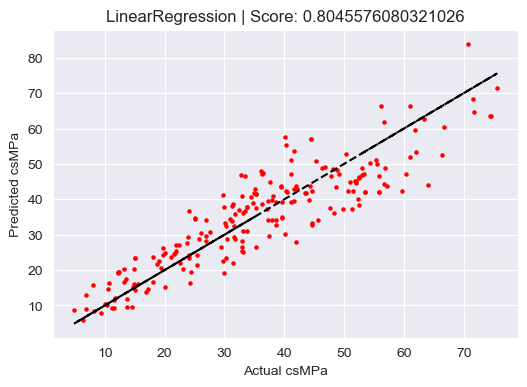

Training Score    0.785292
Testing Score     0.804558
Difference        0.019300
dtype: float64
                     Metric      Score
0                      RMSE   7.096548
1        mean_squared_error  50.360989
2                  r2_score   0.804558
3       mean_absolute_error   5.752149
4  explained_variance_score   0.805312
5           cross_val_score   0.779001


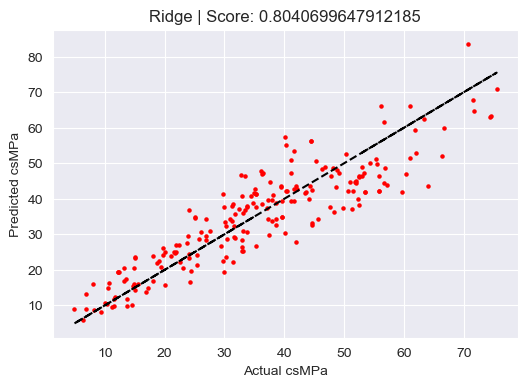

Training Score    0.785137
Testing Score     0.804070
Difference        0.018900
dtype: float64
                     Metric      Score
0                      RMSE   7.105395
1        mean_squared_error  50.486643
2                  r2_score   0.804070
3       mean_absolute_error   5.762296
4  explained_variance_score   0.804835
5           cross_val_score   0.779098


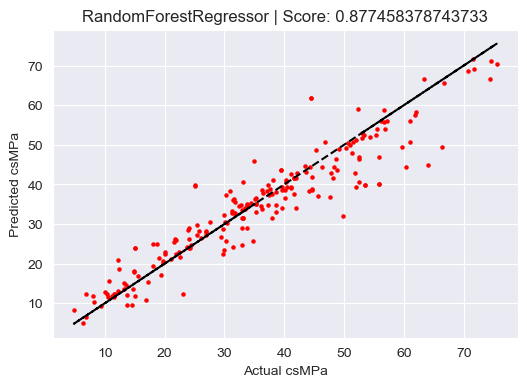

Training Score    0.984739
Testing Score     0.877458
Difference        0.107300
dtype: float64
                     Metric      Score
0                      RMSE   5.619265
1        mean_squared_error  31.576144
2                  r2_score   0.877458
3       mean_absolute_error   3.829403
4  explained_variance_score   0.880141
5           cross_val_score   0.896236


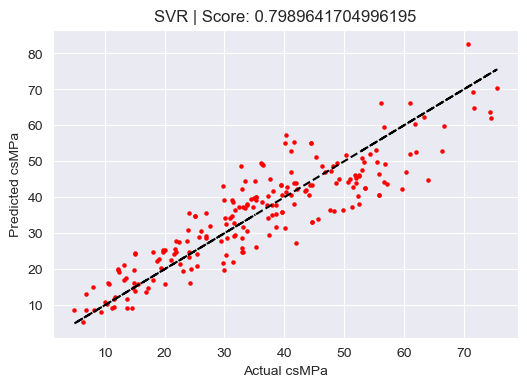

Training Score    0.782397
Testing Score     0.798964
Difference        0.016600
dtype: float64
                     Metric      Score
0                      RMSE   7.197381
1        mean_squared_error  51.802288
2                  r2_score   0.798964
3       mean_absolute_error   5.779545
4  explained_variance_score   0.799308
5           cross_val_score   0.778598


In [17]:
# List of regressors and metrics to be used for the regression model.
regressors = [LinearRegression, Ridge, RandomForestRegressor, SVR]
metriclist = [RMSE, mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, cross_val_score]

for r in regressors:
    if r is LinearRegression:
        model = RegressionModel(x_train, x_test, y_train, y_test, r)
    elif r is Ridge:
        model = RegressionModel(x_train, x_test, y_train, y_test, r, alpha = 0.5, random_state = 42)
    elif r is RandomForestRegressor:
        model = RegressionModel(x_train, x_test, y_train, y_test, r, n_estimators = 200, max_depth = 15, random_state = 42)
    else:
        model = RegressionModel(x_train, x_test, y_train, y_test, r, kernel = 'linear', C = 100, epsilon = 0.8)
    model.Plot()
    
    print(model.RegScores())            # To compare the regression model scores for the training and testing data.
    print(model.Metric(metriclist))     # To evaluate the regression model error analysis using the specified metrics.

### Final observations from the regression models
With reference to the reference link below, this model provides a **'Good'** score, with predicted scores within **80-90%** across all regression models. This means the applied transformations were fairly accurate to what actual relationships are between input variables and the compressive strength - the scores can be increased if the right relationships are precisely found. Complex relationships with compressive strength that were unable to be identified are possible, in particular for the variables **water**, **fine aggregate** and **coarse aggregate**. Below follows the interpretation from the models.

<u>Ensemble methods are too complex to provide help in finding coefficients.</u> Given how RandomForest (RF) works, it is **not possible to convert feature importance(s) of each variable to a coefficient** - hence it is regarded as a 'black box'. Furthermore, a large difference in scores between training and test data would indicate over-fitting on the training data. However, because its predictivity the closest to 100%, the <i>feature importance(s)</i> function will be used to determine which variable is the most important contributor to the overall compressive strength.

All predicted models became less accurate for **very high values of compressive strength**. This is expected, due to transformations resulting in under-fitted data, as well as sensitivity to outliers, especially affecting the variables that are highly skewed.
  
#### Most reasonable choice of regression: **Linear Regression**
It outperformed the other simpler regression models with a lower RMSE and higher R squared score.
Reference link: https://stephenallwright.com/good-accuracy-score/#:~:text=There%20is%20a%20general%20rule%20when%20it%20comes,and%2070%25%20-%20OK%20Below%2060%25%20-%20Poor

### Finding the most important feature to compressive strength

In [18]:
'''Using RFRegressorCoeffs and SVRCoeffs as mentioned from above observations.'''
LinearCoeffs = RegressionModel(x_train, x_test, y_train, y_test, LinearRegression).Coefficients()
RFRegressorCoeffs = RegressionModel(x_train, x_test, y_train, y_test, RandomForestRegressor, n_estimators = 200, max_depth = 15, random_state = 42).Coefficients()

age                 0.335162
cement              0.334176
water               0.130954
slag                0.082131
superplasticizer    0.052242
fineaggregate       0.036602
coarseaggregate     0.028732
dtype: float64


<Axes: >

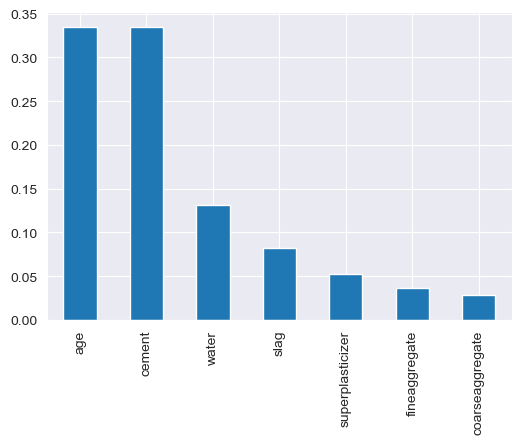

In [19]:
'''Provides the feature importance scores in descending order - a bar graph to help visualise.'''
print(pd.Series(RFRegressorCoeffs, index=TCD.columns[:-1]).sort_values(ascending=False))
pd.Series(RFRegressorCoeffs, index=TCD.columns[:-1]).sort_values(ascending=False).plot(kind='bar', figsize=(6, 4)) # For visualisation.

#### **Age** is the most important feature that contributes to the compressive strength.

### Obtaining the coefficients of each variable for the interactive graph

In [20]:
'''Provides the coefficients for each variable in the linear regression model.'''
print(pd.Series(LinearCoeffs, index=TCD.columns[:-1]))
print('\033[1m' + 'Reminder: these coefficients (m) describe a linear relationship between the transformed, \n          scaled feature and the non-transformed, non-scaled compressive strength, i.e. y = mx + b. ' + '\033[0m')

cement              34.777593
slag                11.260065
water              -31.614230
superplasticizer     8.110574
coarseaggregate     -4.413500
fineaggregate       -9.520438
age                 33.377124
dtype: float64
Reminder: these coefficients (m) describe a linear relationship between the transformed, 
          scaled feature and the non-transformed, non-scaled compressive strength, i.e. y = mx + b. 


# **Interactive Graph**
**Function code still needs to be fixed** - Using non-scaled data for the interactive graph

In [21]:
%matplotlib qt

def InteractiveGraph(variable_coeff):
    '''Plots an interactive graph using the coefficients of our chosen regression model, SVR.'''
    def f(cement, slag, water, superplasticizer, coarseaggregate, fineaggregate, age):
        # Using transformations in Preprocessing section.
        y = ((1.4*np.exp(1-28/age)) * (((variable_coeff[0]*np.sqrt(cement)))
              + (variable_coeff[1]*np.log(slag+1))
                + (variable_coeff[2]*water)
                  + (variable_coeff[3]*np.sqrt(superplasticizer**(4/3)))
                    + (variable_coeff[4]*coarseaggregate)
                     + (variable_coeff[5]*fineaggregate)))              # Note that flyash is removed. 
        return y
        
    # Create subplot
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.5) 
    ax.set(xlabel='Age', ylabel='Compression Strength (MPa)')

    # Create and plot basic strength against age plot using the mean values of each variable for the initial plot
    t = np.arange(0.1, 365, 1)
    line = f(TCD.mean().iloc[0], TCD.mean().iloc[1], TCD.mean().iloc[2], TCD.mean().iloc[3], TCD.mean().iloc[4], TCD.mean().iloc[5], t)
    l, = plt.plot(t, line)

    #Create reset button to go back to the mean value
    resetax = fig.add_axes([0.025, 0.025, 0.1, 0.04])
    button = Button(resetax, 'Reset', color='0.95', hovercolor='0.7')
    
    #Create sliders for each variable and add them to list Sliders
    def create_Sliders():
        Sliderlist = []
        for i, column in enumerate(TCD.columns[:-2]):
            #plot each slider in a given location, each moving up by 0.5 to get a good spread
            axvariable = plt.axes([0.25, 0.05*(i + 1), 0.65, 0.03])
            var_slider = Slider(axvariable, label = column, valmin = TCD.min().iloc[i], valmax = TCD.max().iloc[i], valinit = TCD.mean().iloc[i])
            #Add each slider to Sliders list for access later
            Sliderlist.append(var_slider)
        return Sliderlist
    
    #Calling the defined function
    Sliders = create_Sliders()

    #The function to be called anytime a slider's value changes which also updates the graph
    def update(val):
        l.set_ydata(f(Sliders[0].val, Sliders[1].val, Sliders[2].val, Sliders[3].val, Sliders[4].val, Sliders[5].val, t))
        ax.relim()
        ax.autoscale_view(True,True,True)
        fig.canvas.draw_idle()
    
    #Register the update function with each slider
    for i in range(len(TCD.columns[:-2])):
        Sliders[i].on_changed(update)
            
    #This function implements the reset button such that the sliders are brought back to there initial value
    def reset(event):
        for i in range(len(TCD.columns[:-2])):
            Sliders[i].reset()
    button.on_clicked(reset)

    resetax._button = button
    plt.show()
    return

In [22]:
'''To run the Interactive Graph - will open a new tab.'''
w = InteractiveGraph(LinearCoeffs)
w

NB: For high values of age seen in the interactive graph, the predictor becomes less accurate with reasoning mentioned from 'Final Observations'.